#Plants Seedling Classification - Problem Statement

###Background and Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

###Objective

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

###Data Description

This dataset contains images of unique plants belonging to 12 different species.

The data file names are:
  - images.npy
  - Label.csv

    - Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.
- The goal of the project is to create a classifier capable of determining a plant's species from an image.

###List of Plant species

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

##Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg 
import seaborn as sns

import tensorflow as tf
import keras
import os
import cv2
import math
import random

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, ReLU
from tensorflow.keras import backend, losses, optimizers, layers
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.vgg16 import VGG16  
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelBinarizer

from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
images = np.load('/content/drive/MyDrive/Python Course/Plant_images.npy')
labels = pd.read_csv('/content/drive/MyDrive/Python Course/Plant_Labels.csv')

In [4]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


- We have 4750 images in our dataset with the shape 128 x 128 X 3, each image having 3 channels, being the color channels RGB.

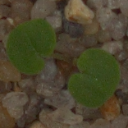

In [4]:
cv2_imshow(images[9])

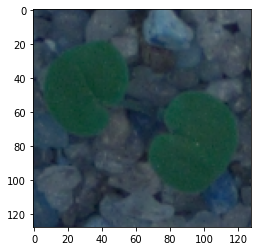

In [5]:
plt.imshow(images[9])

- As we can see from the 2 photos above, the first image, using OpenCV is displaying the image using BGR format, which matches the color format for our original image data. 
- The second image was generated using matplotlib, which uses the RGB format. Since the B and R positions are switched it is causeing matplotlib to display the picture's red areas as blue and vice versa.
- We can correct this though by converting the BGR images to BGR so that we will be able to display the correct colors using matplotlib.

In [6]:
# Convert images from BGR to RGB
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

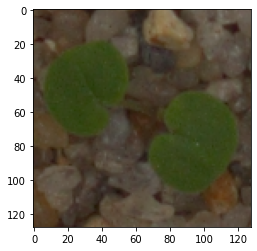

In [7]:
plt.imshow(images[9])

- We can now see the correct colors when viewing the image using matplotlib

#Exploratory Data Analysis

In [8]:
# visualizing an example of some of the different image classes
def view_images(images, labels):
    num_classes=12
    categories=np.unique(labels)
    keys=dict(labels['Label'])
    rows=4
    cols=4
    fig = plt.figure(figsize=(12,14))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(labels))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.imshow(images[random_index, :])
            ax.set_title(keys[random_index])
    plt.show()

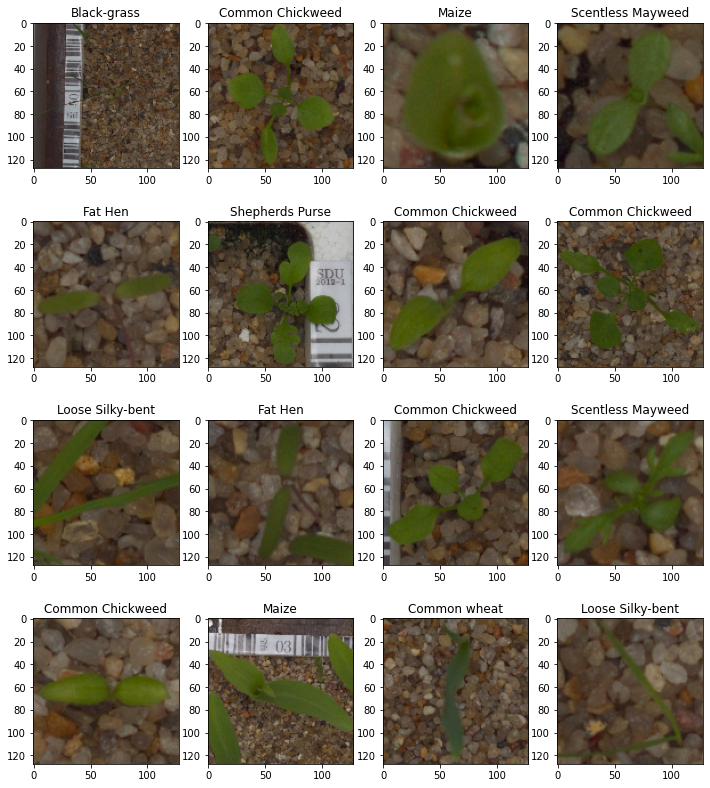

In [9]:
view_images(images, labels)

- Here we can see a good sampling of some of the different seedling classes in our dataset.

###Class Balance

Let's take a look at how many images we have for each of the 12 different classes in order to see the balnce amongst our classes.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

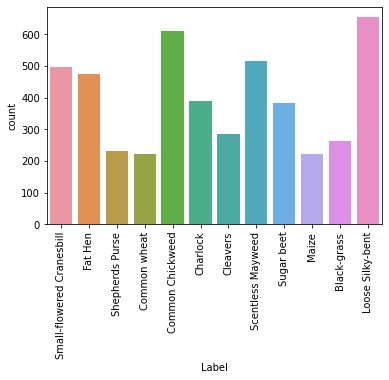

In [10]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

###Summary of EDA

- Our data looks to be quite imbalanced between classes
- The Common Chickweed and Loose Silky-bent classes have significantly more images in the data and roughly 3x as many images as Shepherds Purse, Common wheat, Maize, or Black-grass.
- This imbalance poses a significant problem in our CNN being able accurately learn and predict when the classes are this uneven. We will need to correct for this data imbalance by weighting each class based on their overall ratio in the data. Doing so will increase the weight given to the minority classes and help to correct this class imbalance when our CNN learns from the training data.

#Data Pre-processing

###Gaussian Blur

Let's try viewing an image with the Gaussian Blue effect added to see if reducing the noise in our images might add anything to help feature identification.

In [11]:
# Applying Gaussian Blur to our images
gb_images = []
for i in range(len(images)):
    gb_images.append(cv2.GaussianBlur(images[i], ksize=(3,3), sigmaX=0))

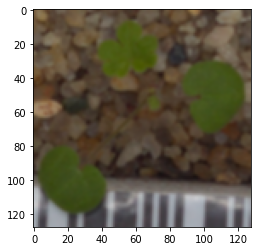

In [12]:
plt.imshow(gb_images[32])

- Above we can see an image from our dataset with the Gaussian Blur effect applied.

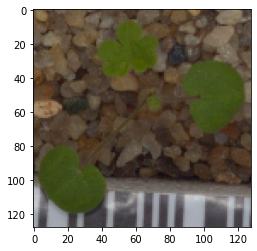

In [13]:
plt.imshow(images[32])

- This is the same image from our dataset but without the Gaussian Blur. We can see from this picture that our background is full of small rocks all of which have edges that our CNN would be attempting to extract as features, and would most likey give us poor results. There are also markers in some of the pictures, like this one, which also contain lines and edges that may pose an issue in classification.
- In the case of this dataset I do believe it would be beneficial to use a Gaussian Blur as it will create a slight blur reducing the noise created by all the lines and edges in the background of our images.

###Split the dataset

In [14]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(gb_images), labels, test_size=0.1, random_state=1, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=1, stratify=y_temp)

In [15]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 128, 128, 3) (3847, 1)
(428, 128, 128, 3) (428, 1)
(475, 128, 128, 3) (475, 1)


Now that we have split our data we can work on fixing the class imbalance.

In [16]:
# Adjusting class weights to correct for the imbalanced classes in our data
from sklearn.utils import class_weight

LabelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(LabelList),
                                                  y = y_train.values.reshape(-1))
class_weights = dict(zip(np.array(range(len(LabelList))), class_weights))
class_weights

{0: 0.7974709784411277,
 1: 0.8348524305555556,
 2: 1.714349376114082,
 3: 1.7909683426443204,
 4: 0.6476430976430977,
 5: 1.0145042194092826,
 6: 1.3818247126436782,
 7: 0.7669457735247209,
 8: 1.0275106837606838,
 9: 1.7909683426443204,
 10: 1.5050860719874803,
 11: 0.604874213836478}

- Our classes have now been weighted accordingly to accomodate the class imbalance that was present in our data.

###Encoding our target labels

- We will use the LabelBinarizer to encode our target labels

In [17]:
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_val_encoded = lb.transform(y_val)
y_test_encoded = lb.transform(y_test)


###Data Normalization
- Our images have pixel values that range from 0-255, we can divide all the pixel values by 255 so that our images will be scaled to have values between 0-1.

In [18]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

#Model Building

The 1st model we are going to build will be a basic Sequential CNN model

In [ ]:
# first we will clear the backend
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
model = Sequential()

model.add(Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

Now we have our 1st CNN model with 358,748 total parameters. Let's fit our CNN on the training data and see how it performs.

In [ ]:
history = model.fit(X_train_normalized, 
                    y_train_encoded, 
                    epochs=25, 
                    validation_data=(X_val_normalized, y_val_encoded), 
                    batch_size=32, 
                    verbose=1)

Epoch 1/25
121/121 [==============================] - 17s 44ms/step - loss: 2.4442 - accuracy: 0.1141 - val_loss: 2.4209 - val_accuracy: 0.1262
Epoch 2/25
121/121 [==============================] - 4s 34ms/step - loss: 2.4009 - accuracy: 0.1424 - val_loss: 2.3416 - val_accuracy: 0.1682
Epoch 3/25
121/121 [==============================] - 4s 33ms/step - loss: 2.1280 - accuracy: 0.2745 - val_loss: 1.8593 - val_accuracy: 0.4089
Epoch 4/25
121/121 [==============================] - 4s 33ms/step - loss: 1.8039 - accuracy: 0.3618 - val_loss: 1.6233 - val_accuracy: 0.4322
Epoch 5/25
121/121 [==============================] - 4s 34ms/step - loss: 1.6645 - accuracy: 0.3993 - val_loss: 1.5545 - val_accuracy: 0.4673
Epoch 6/25
121/121 [==============================] - 4s 33ms/step - loss: 1.6057 - accuracy: 0.4115 - val_loss: 1.4890 - val_accuracy: 0.4883
Epoch 7/25
121/121 [==============================] - 4s 33ms/step - loss: 1.5267 - accuracy: 0.4427 - val_loss: 1.5004 - val_accuracy: 0.523

###Model Evaluation Plot

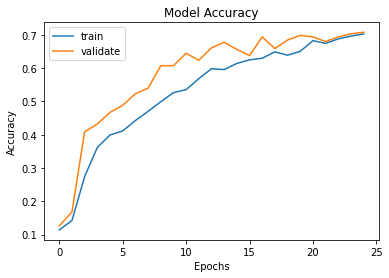

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

- Our validation accuracy started out a bit higher than our training data and it continued to increase at a higher rate, but eventually converged with our training data around epochs 21-25.
- Our model made it to 70% on both training and validation data so I would say that our model is doing a decent job at generalizing. Let's see how it performs on our test data.

###Evaluating model on test data

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.1201 - accuracy: 0.6989 - 518ms/epoch - 35ms/step


- 69.89% accuracy based on our first CNN model is a fairly good result, lining up with our training and validation data.
- Let's see how the predictions turned out using our test data.

In [ ]:
y_pred = model.predict(X_test_normalized)

15/15 [==============================] - 0s 8ms/step


Let's plot a confusion matrix to visualize our model's predictions

              precision    recall  f1-score   support

           0       0.40      0.08      0.13        26
           1       0.77      0.69      0.73        39
           2       0.73      0.76      0.75        29
           3       0.86      0.93      0.90        61
           4       0.00      0.00      0.00        22
           5       0.60      0.71      0.65        48
           6       0.55      0.94      0.70        65
           7       0.90      0.82      0.86        22
           8       0.67      0.71      0.69        52
           9       0.74      0.61      0.67        23
          10       0.93      0.82      0.87        50
          11       0.56      0.50      0.53        38

    accuracy                           0.70       475
   macro avg       0.64      0.63      0.62       475
weighted avg       0.67      0.70      0.67       475



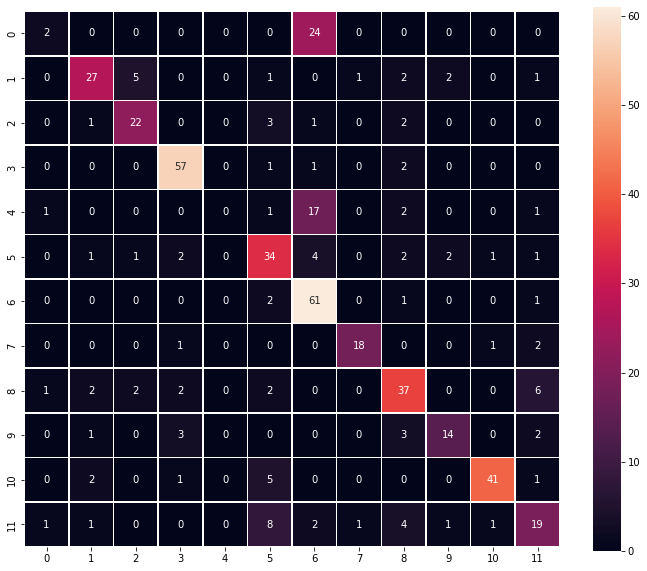

In [ ]:
# using np.argmax to get categorical values from our encoded test data and y_pred probabilities
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# print classification report
print(classification_report(y_test_arg, y_pred_arg))

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt='d',
    square=True,
    ax=ax
)
plt.show()

- Our model seems to be predicting quite well for most classes but it has a good deal of trouble when it comes to classes 0, and 4.
- It is misclassifying both class 0 and class 4 as primarily class 6, yet the model has one of its highest success rates on identifying the actual class 6 correctly.
- Perhaps creating more training data with data augmentation will help our next model improve on being able to classify these plants correctly.

# Model 2

- For Model 2 we will see if we can improve upon classification by using Data Augmentation in order to generate more training data for our model.
- Hopefully with an increased amount of training data our 2nd model will be able to better distinguish class 0 and 4 as being different from class 6 once it has more examples to train on.
- We will also try adding BatchNormalization to our convoluted layer to see if it will help improve results.

In [ ]:
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

Now before we build this 2nd model we will create an augmented dataset in order increase the size of our data by flipping the images horizontally, as will as rotating the images 25 degrees.  Adding these additional flipped and rotated images gives our model a lot more data to train on.


In [21]:
# Augmenting our data to increase training images using several different techniques
train_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rotation_range=25,
                                   fill_mode='nearest')

In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(128,128,3)))
model_2.add(MaxPooling2D((2,2), padding='same'))

model_2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2,2), padding='same'))

model_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2,2), padding='same'))

model_2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2,2), padding='same'))
model_2.add(BatchNormalization())

model_2.add(Flatten())

model_2.add(Dense(128, activation='relu'))

model_2.add(Dense(64, activation='relu'))

model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.2))
            
model_2.add(Dense(16, activation='relu'))

model_2.add(Dense(12, activation='softmax'))

In [ ]:
optimizer = Adam()
model_2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

- Our 2nd model has a total of 667,932 total parameters with 667,868 trainable parameters and 64 non-trainable parameters due to the BatchNormalization that we added to our convolutional layers.
- This is more trainable parameters than our 1st model, and with our data augmentation this model will also have more images to train on then our 1st model.
- We have also increased the layers for our model's architecture in both the convoluted and fully connected portions.



In [ ]:
history_2 = model_2.fit(train_datagen.flow(X_train_normalized, 
                                                 y_train_encoded,
                                                 seed=1,
                                                 shuffle=False),
                                                 batch_size=32,
                                                 epochs=20,
                                                 steps_per_epoch=X_train_normalized.shape[0] // 32,
                                                 validation_data=(X_val_normalized, y_val_encoded),
                                                 verbose=1)

Epoch 1/20
120/120 [==============================] - 21s 144ms/step - loss: 2.3568 - accuracy: 0.1751 - val_loss: 2.3297 - val_accuracy: 0.3505
Epoch 2/20
120/120 [==============================] - 17s 141ms/step - loss: 1.7503 - accuracy: 0.4102 - val_loss: 2.1287 - val_accuracy: 0.2850
Epoch 3/20
120/120 [==============================] - 21s 172ms/step - loss: 1.4118 - accuracy: 0.5101 - val_loss: 1.3632 - val_accuracy: 0.5421
Epoch 4/20
120/120 [==============================] - 18s 147ms/step - loss: 1.2365 - accuracy: 0.5759 - val_loss: 1.5285 - val_accuracy: 0.5257
Epoch 5/20
120/120 [==============================] - 17s 145ms/step - loss: 1.1044 - accuracy: 0.6288 - val_loss: 2.4201 - val_accuracy: 0.3598
Epoch 6/20
120/120 [==============================] - 17s 141ms/step - loss: 0.9992 - accuracy: 0.6632 - val_loss: 0.9058 - val_accuracy: 0.7313
Epoch 7/20
120/120 [==============================] - 18s 150ms/step - loss: 0.9531 - accuracy: 0.6883 - val_loss: 1.8515 - val_ac

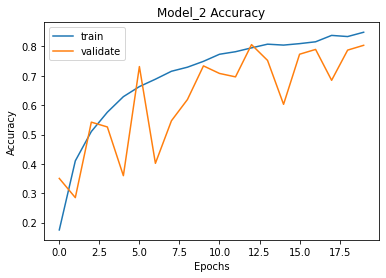

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model_2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

###Evaluating model_2 on the test data

In [ ]:
accuracy = model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 0.6880 - accuracy: 0.7684 - 876ms/epoch - 58ms/step


- Our 2nd model is overfitting, however, our Test Accuracy has improved to 76.84% which is better our 1st model's test accuracy of 69.89%
- Let's plot a confusion matrix to see how our 2nd model does for the predicting the different classes.

In [ ]:
y_pred_2 = model_2.predict(X_test_normalized)

15/15 [==============================] - 0s 20ms/step


              precision    recall  f1-score   support

           0       0.42      0.62      0.50        26
           1       0.82      0.85      0.84        39
           2       0.76      0.66      0.70        29
           3       0.75      0.97      0.84        61
           4       0.63      0.77      0.69        22
           5       0.75      0.79      0.77        48
           6       0.84      0.57      0.68        65
           7       0.68      0.95      0.79        22
           8       0.95      0.73      0.83        52
           9       1.00      0.74      0.85        23
          10       0.92      0.90      0.91        50
          11       0.74      0.66      0.69        38

    accuracy                           0.77       475
   macro avg       0.77      0.77      0.76       475
weighted avg       0.79      0.77      0.77       475



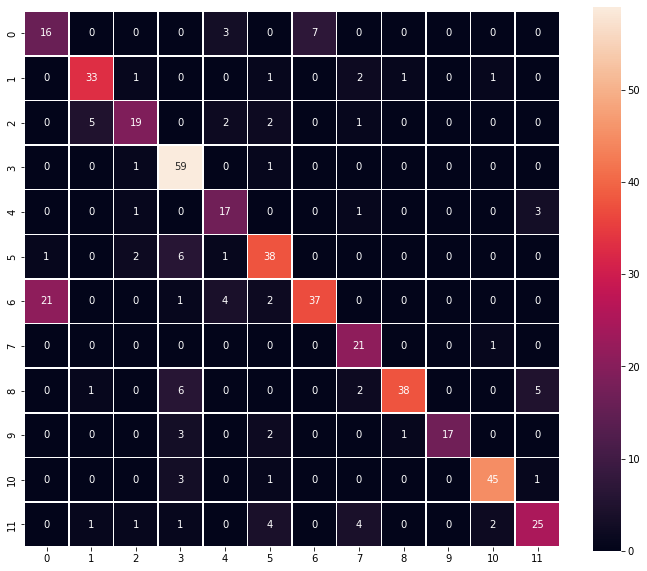

In [ ]:
# using np.argmax to get categorical values from our encoded test data and y_pred probabilities
y_pred_2_arg = np.argmax(y_pred_2, axis=1)
y_test_2_arg = np.argmax(y_test_encoded, axis=1)

# print classification report
print(classification_report(y_test_2_arg, y_pred_2_arg))

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_2_arg, y_pred_2_arg)
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt='d',
    square=True,
    ax=ax
)
plt.show()

- Our 2nd model is definitely doing better at predicting class 0 and 4, but is now predicting a bunch of class 6 incorrectly as class 0. So our model is still having some trouble distinguishing between classes 0 and 6.

- Let's try using transfer learning in our next model to see if we can improve our accuracy more and hopefully get our model to better predict classes 0 and 6 correctly.

#Model 3

- We will build model 3 using transfer learning based on the VGG16 model's architecture.
- We will take convolutional and pooling layers from the VGG16 model and freeze their weights so that we won't have to retrain them. The weights we are going to use from the VGG16 model were already trained on identifying images using a large dataset known as ImageNet.
- Once we add in the VGG16 convolutional architecture, we will just need to create our own fully connected layers. Since we are freezing all the weights from the VGG16 convolutional layers we will only need to train the weights for the fully connected layers we add, despite our model having many more parameters than our previous 2 models.

In [82]:
# Importing VGG16 model, settings weights to imagenet to use those paramenters
# Also setting include_top to False so that we do not import the fully connected layers
model_3_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_3_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

- Here we can see the model summary of the VGG16 convolutional layers
- There are 14,714,688 total parameters in just this portion of the model, which is way more than the amount of parameters for either of our 1st two models. Thankfully we won't have to retrain these parameters so it will be less computationally heavy, but give our model_3 way more parameters to work with.

In [83]:
# clearing the backend of previous model data before creating our new model.
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

###Data Augmentation
- Since the VGG16 model has so many parameters a bigger dataset would really be more beneficial in order to get good results.  So we are going to generate a new set of augmented data with additional modifications to increase our data set further.

In [19]:
train_datagen_vgg16 = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rotation_range=25,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode='nearest')

In [84]:
# freezing all layers of the VGG model so they will not need to be trained again
for layer in model_3_vgg.layers:
    layer.trainable=False

We will also try adding a kernel initializer to our fully connected layers to see if that will help improve our results.

In [20]:
from tensorflow.keras.initializers import he_uniform

In [85]:
model_3 = Sequential()

# adding the VGG16 model for our convolutional layers
model_3.add(model_3_vgg)

model_3.add(Flatten())

model_3.add(Dense(256, kernel_initializer='he_uniform', activation='relu'))
model_3.add(BatchNormalization())

model_3.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
model_3.add(BatchNormalization())

model_3.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
model_3.add(BatchNormalization())

model_3.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))

model_3.add(Dense(12, activation='softmax'))

In [86]:
model_3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

As you can see model_3 has 15,241,852 total parameters, yet only 527,436 of them are trainable which is similar to the number of trainable parameters we had in model_2.

- For this model we are also adding a callback for early stopping. If val_loss is not improving for 5 epochs then this call back will stop the model as it does not seem to be improving any further.
- The second callback we will use is for model checkpoint which will save the best model as it improves over each epoch.

In [87]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

- We are also going to set shuffle=True this time to help prevent bias

In [88]:
history_3 = model_3.fit(train_datagen_vgg16.flow(X_train_normalized, 
                                                 y_train_encoded,
                                                 seed=1,
                                                 shuffle=True),
                                                 batch_size=32,
                                                 epochs=20,
                                                 steps_per_epoch=X_train_normalized.shape[0] // 32,
                                                 validation_data=(X_val_normalized, y_val_encoded),
                                                 callbacks=[es, mc],
                                                 verbose=1)

Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 1.9449 - accuracy: 0.3554
Epoch 1: val_accuracy improved from -inf to 0.23364, saving model to best_model.h5
120/120 [==============================] - 22s 155ms/step - loss: 1.9449 - accuracy: 0.3554 - val_loss: 2.6037 - val_accuracy: 0.2336
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 1.3568 - accuracy: 0.5311
Epoch 2: val_accuracy improved from 0.23364 to 0.51636, saving model to best_model.h5
120/120 [==============================] - 19s 157ms/step - loss: 1.3568 - accuracy: 0.5311 - val_loss: 1.4777 - val_accuracy: 0.5164
Epoch 3/20
120/120 [==============================] - ETA: 0s - loss: 1.1781 - accuracy: 0.5984
Epoch 3: val_accuracy improved from 0.51636 to 0.53972, saving model to best_model.h5
120/120 [==============================] - 17s 145ms/step - loss: 1.1781 - accuracy: 0.5984 - val_loss: 1.4079 - val_accuracy: 0.5397
Epoch 4/20
120/120 [==============================] - E

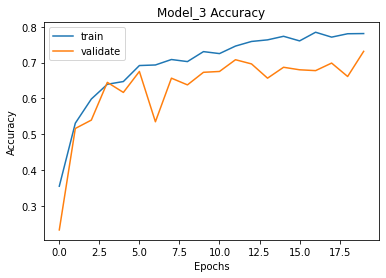

In [89]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model_3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

- Here we see some overfitting as well some noise in the validation data, but overall our validation data follows the training data more closely then model 2 with less noise. 
- The overall train and validation accuracy is lower than model 2.

###Evaluating model_3 on the test data

In [90]:
accuracy = model_3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 0.7848 - accuracy: 0.7453 - 731ms/epoch - 49ms/step


- Test accuracy was only 73.89% which is lower then the 76.84% we achieved with model 2. I am somewhat surprised by this result as I thought the greatly increased number of parameters with already trained weights would have had an even higher accuracy.

In [67]:
y_pred_3 = model_3.predict(X_test_normalized)

15/15 [==============================] - 1s 45ms/step


              precision    recall  f1-score   support

           0       0.62      0.38      0.48        26
           1       0.84      0.82      0.83        39
           2       0.82      0.62      0.71        29
           3       0.89      0.92      0.90        61
           4       0.67      0.45      0.54        22
           5       0.53      0.79      0.63        48
           6       0.72      0.82      0.76        65
           7       0.86      0.82      0.84        22
           8       0.79      0.58      0.67        52
           9       0.48      0.65      0.56        23
          10       0.83      0.86      0.84        50
          11       0.85      0.74      0.79        38

    accuracy                           0.74       475
   macro avg       0.74      0.70      0.71       475
weighted avg       0.75      0.74      0.74       475



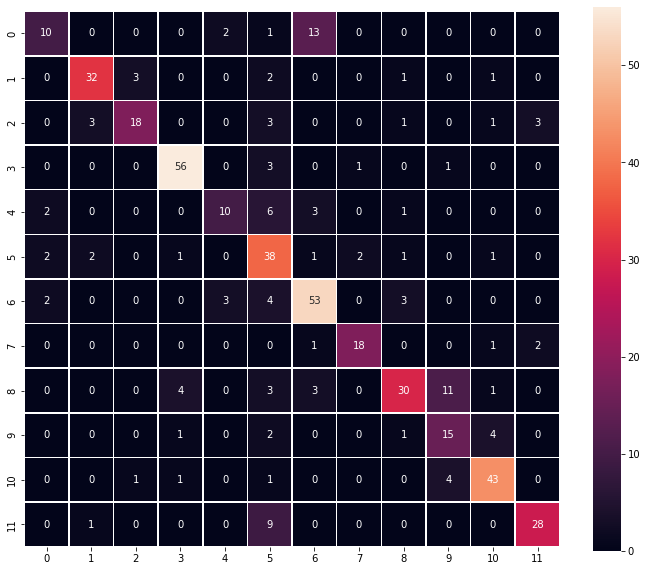

In [68]:
# using np.argmax to get categorical values from our encoded test data and y_pred probabilities
y_pred_3_arg = np.argmax(y_pred_3, axis=1)
y_test_3_arg = np.argmax(y_test_encoded, axis=1)

# print classification report
print(classification_report(y_test_3_arg, y_pred_3_arg))

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_3_arg, y_pred_3_arg)
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt='d',
    square=True,
    ax=ax
)
plt.show()

- model_3 may a little less accurate than model_2, but it does a decent job at predicting across all the classes with exception of class 0 which it still struggles with misidentifying it as class 6.
- Class 6 predictions have greatly improved though vs. model_2.

#Model 4
- We are going to try one more model to see if we can't use the VGG16 architecture to improve our results. 
- This time instead of using all 5 blocks of the convolutional layer from VGG16, we will only use 4 blocks and create our own additional convolutional layers on top of the 4 blocks in order to try and customize the architecture more for our dataset.

In [21]:
# Loading VGG16 model 
model_4_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [52]:
# Getting only the 1st 4 blocks of the VGG16 convolutional layers for transfer learning.
transfer_layer = model_4_vgg.get_layer('block4_pool')
model_4_block_4 = Model(inputs=model_4_vgg.input, outputs=transfer_layer.output)

In [53]:
# summary of VGG16 blocks 1-4
model_4_block_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

- As we can see this has greatly reduced the number of parameters from the previous model. Hopefully this will improve our results as our dataset may not be large enough for the full VGG16 convolutional architecture, and that could be why we were not able to improve our results on model_3.

In [69]:
# clearing the backend of previous model data before creating our new model.
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [70]:
# freezing the 4 convolutional layers of the VGG model so they will not need to be trained again
for layer in model_4_block_4.layers:
    layer.trainable=False

- For model_4 we are going to continue using the kernel initializer and batch normalization.
- We have also added an instance of batch normalization within the convolutional layers.

In [71]:
model_4 = Sequential()

# adding the VGG16 model for our convolutional layers
model_4.add(model_4_block_4)

model_4.add(Conv2D(8, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D((2,2), padding='same'))
model_4.add(BatchNormalization())

model_4.add(Conv2D(8, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D((2,2), padding='same'))

model_4.add(Flatten())

model_4.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
model_4.add(BatchNormalization())

model_4.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))

model_4.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))

model_4.add(Dense(12, activation='softmax'))

In [72]:
model_4.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 512)         7635264   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 8)           36872     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 8)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 8)          32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 8)          0

- Our trainable parameters have been reduced to less than 100,000 making this the model with the least amount of trainable parameters across all 4 of our models.

In [73]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [74]:
history_4 = model_4.fit(train_datagen_vgg16.flow(X_train_normalized, 
                                                 y_train_encoded,
                                                 seed=1,
                                                 shuffle=True),
                                                 batch_size=32,
                                                 epochs=20,
                                                 steps_per_epoch=X_train_normalized.shape[0] // 32,
                                                 validation_data=(X_val_normalized, y_val_encoded),
                                                 callbacks=[es, mc],
                                                 verbose=1)

Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 2.3524 - accuracy: 0.2118
Epoch 1: val_accuracy improved from -inf to 0.13318, saving model to best_model.h5
120/120 [==============================] - 22s 148ms/step - loss: 2.3524 - accuracy: 0.2118 - val_loss: 3.0536 - val_accuracy: 0.1332
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 1.7940 - accuracy: 0.3785
Epoch 2: val_accuracy improved from 0.13318 to 0.34112, saving model to best_model.h5
120/120 [==============================] - 17s 143ms/step - loss: 1.7940 - accuracy: 0.3785 - val_loss: 1.9040 - val_accuracy: 0.3411
Epoch 3/20
120/120 [==============================] - ETA: 0s - loss: 1.4743 - accuracy: 0.4779
Epoch 3: val_accuracy improved from 0.34112 to 0.50701, saving model to best_model.h5
120/120 [==============================] - 19s 154ms/step - loss: 1.4743 - accuracy: 0.4779 - val_loss: 1.3373 - val_accuracy: 0.5070
Epoch 4/20
120/120 [==============================] - E

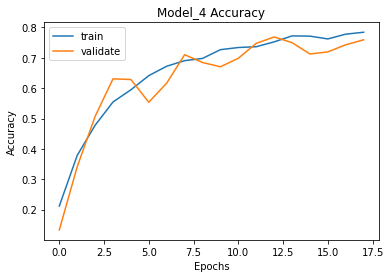

In [75]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model_4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

- Here we still see noise in our validation accuracy as we see some spikes and dips but overall if follows the training closely so I would say we are seeing some generalization from this model.

In [76]:
accuracy = model_4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 0.6083 - accuracy: 0.7874 - 676ms/epoch - 45ms/step


- Our test accuracy is 78.74% which is the highest test accuracy we have achieved across all 4 models.

In [77]:
y_pred_4 = model_4.predict(X_test_normalized)

15/15 [==============================] - 1s 41ms/step


              precision    recall  f1-score   support

           0       0.60      0.35      0.44        26
           1       0.72      0.92      0.81        39
           2       0.70      0.72      0.71        29
           3       0.95      0.89      0.92        61
           4       0.73      0.73      0.73        22
           5       0.77      0.77      0.77        48
           6       0.75      0.88      0.81        65
           7       0.84      0.95      0.89        22
           8       0.86      0.71      0.78        52
           9       0.56      0.78      0.65        23
          10       0.96      0.88      0.92        50
          11       0.77      0.63      0.70        38

    accuracy                           0.79       475
   macro avg       0.77      0.77      0.76       475
weighted avg       0.79      0.79      0.78       475



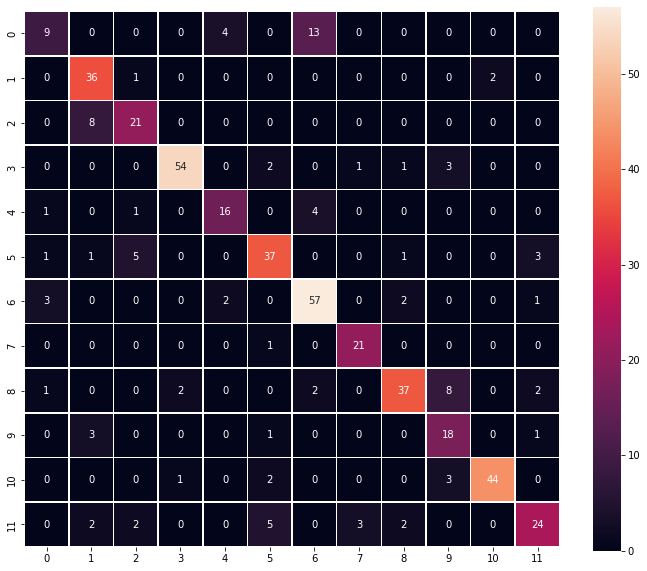

In [78]:
# using np.argmax to get categorical values from our encoded test data and y_pred probabilities
y_pred_4_arg = np.argmax(y_pred_4, axis=1)
y_test_4_arg = np.argmax(y_test_encoded, axis=1)

# print classification report
print(classification_report(y_test_4_arg, y_pred_4_arg))

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_4_arg, y_pred_4_arg)
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt='d',
    square=True,
    ax=ax
)
plt.show()

- class 0 still seems to be a struggle to classify even for this model with our highest accuracy.
- It does a pretty good job predicting across all of the other classes.

#Let's visualize some predictions using Model 4

- Here we are selecting 3 random pictures from our dataset to see what model 4 predicted them to be vs. what they are actually labeled.

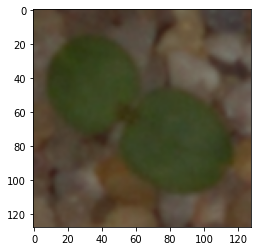

1/1 [==============================] - 1s 587ms/step
Predicted Label ['Cleavers']
True Label Cleavers


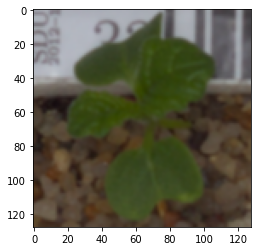

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Charlock']
True Label Charlock


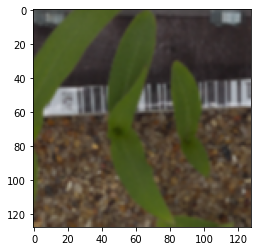

1/1 [==============================] - 0s 27ms/step
Predicted Label ['Maize']
True Label Maize


In [79]:
# Visualizing the predicted and true label of images from test data
plt.figure(figsize=(4,4))
plt.imshow(X_test[8])
plt.show()
# reshaping the input image
print('Predicted Label', lb.inverse_transform(model_4.predict((X_test_normalized[8].reshape(1, 128, 128, 3)))))
# using inverse_transform() to get the output label from the output vector
print('True Label', lb.inverse_transform(y_test_encoded)[8])

plt.figure(figsize=(4,4))
plt.imshow(X_test[61])
plt.show()
print('Predicted Label', lb.inverse_transform(model_4.predict((X_test_normalized[61].reshape(1, 128, 128, 3)))))
print('True Label', lb.inverse_transform(y_test_encoded)[61])

plt.figure(figsize=(4,4))
plt.imshow(X_test[313])
plt.show()
print('Predicted Label', lb.inverse_transform(model_4.predict((X_test_normalized[313].reshape(1, 128, 128, 3)))))
print('True Label', lb.inverse_transform(y_test_encoded)[313])

- Model 4 was able to correctly predict all 3 of these randomly selected pictures.

# Model Comparison

In [92]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Full VGG16 Model', 'Custom Convolutional VGG16'],
              'Train Accuracy':['70.29%','84.82%','78.09%', '78.43%'],
              'Validation Accuracy':['70.79%','80.37%','73.13%', '75.93%'],
              'Test Accuracy':['69.89%','76.84%', '74.53%', '78.74%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,70.29%,70.79%,69.89%
1,CNN Model with Data Augmentation,84.82%,80.37%,76.84%
2,Full VGG16 Model,78.09%,73.13%,74.53%
3,Custom Convolutional VGG16,78.43%,75.93%,78.74%


#Conclusion
- Based on our test accuracy and the confusion matrix for all our models, model 4, using the 1st 4 convolutional blocks of the VGG16 architecture and then adding our own convolutional layers on top as well as the fully connected layers proved to be our best model. 
- The VGG16 architecture is great for classifying images but I believe our dataset just wasn't big enough for the amount of parameters in the full VGG16 convolutional architecture.  Through customizing part of the convolutional layer we were able to greatly reduce the number of parameters from the full VGG16 convolutional architecture while still retaining a large number of parameters with pretrained weights from ImageNet.
- The test accuracy of this model is 78.74%
- Data Augmentation definitely helped in improving our model, which shows that with an even larger dataset we could probably achieve greater accuracy.
- I would reccomend that the Aarhus University Signal Processing group, and University of Southern Denmark, use model 4 in order to best classify their 12 plant species based on my different CNN models.

#Areas of Improvement
- A larger dataset and a greater number of Augmentations applied to the data to further increase the size of the dataset, are probably the 2 biggest factors that would serve to increase accuracy.
- Besides increasing the size of the dataset, there are also so many parameters that can be adjusted, for instance, changing around the layers of batch normalization and dropout, adding more fully connected layers, possibly trying another VGG16 with only the first 3 blocks and adding even more of your own convolutional layers.
- There are of course other transfer learning architectures that can be tried as well, which may achieve better results.